# AI-Powered Churn Prediction System - Future Interns ML Internship Task 2

## Introduction

This notebook details the development of an AI-powered system designed to predict customer churn. Customer churn is a critical problem for businesses as retaining existing customers is often more cost-effective than acquiring new ones. By identifying customers at risk of churning, businesses can implement proactive retention strategies.

This project demonstrates the application of machine learning classification techniques, from data understanding and preprocessing to model building, evaluation, and the generation of actionable business insights.

---

## 1. Data Loading and Initial Inspection

This section covers loading the customer churn dataset, examining its structure, data types, and checking for missing values to understand the initial state of the data.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the filename of your downloaded churn dataset
file_name = 'WA_Fn-UseC_-Telco-Customer-Churn.csv' # <-- REPLACE WITH YOUR ACTUAL FILENAME (e.g., 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Load the dataset
try:
    df = pd.read_csv(file_name)
    print(f"Data loaded successfully from {file_name}!")
except FileNotFoundError:
    print(f"Error: '{file_name}' not found. Please ensure the dataset is uploaded to your Colab session with this exact name.")
    raise # Stop execution if file is not found

# Display the first 5 rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display concise summary of the DataFrame, including data types and non-null counts
print("\nData Info (initial load):")
df.info()

# Check for missing values in each column
print("\nMissing Values before cleaning:")
print(df.isnull().sum())

# Check the unique values and their counts for the target variable ('Churn' or similar)
# Replace 'Churn' with the actual name of your target column
print("\nDistribution of the target variable ('Churn'):")
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True)) # Percentage

Data loaded successfully from WA_Fn-UseC_-Telco-Customer-Churn.csv!

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic      

**Observation:**
The dataset contains 7043 entries and 21 columns, providing a comprehensive view of customer details for churn prediction. Key features include demographic information, service subscriptions, and account specifics, with 'Churn' serving as the target variable.

A critical observation is that the 'TotalCharges' column is currently of `object` (string) data type, despite representing numerical values. This indicates that it may contain non-numeric entries (e.g., empty strings for new customers) which will require careful handling during preprocessing. All other columns initially show no explicit missing values.

The distribution of the target variable 'Churn' is as follows: 5174 customers did not churn (73.46%), while 1869 customers churned (26.54%). This reveals a notable **class imbalance**, with a higher proportion of non-churning customers. This imbalance will need to be addressed during the model training phase to ensure our model effectively learns to predict both classes.

---

## 2. Exploratory Data Analysis (EDA)

This section performs exploratory data analysis to understand the characteristics of the customer data, identify patterns, and visualize the relationships between features and the target 'Churn' variable.

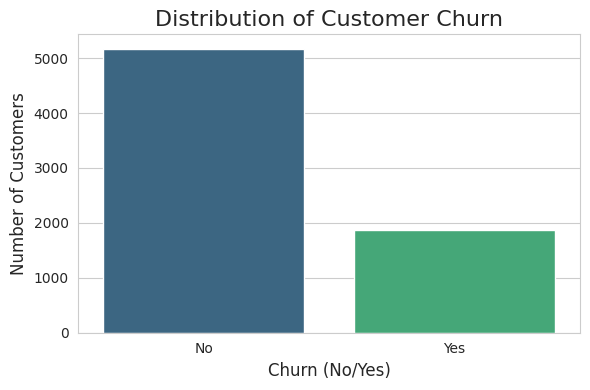

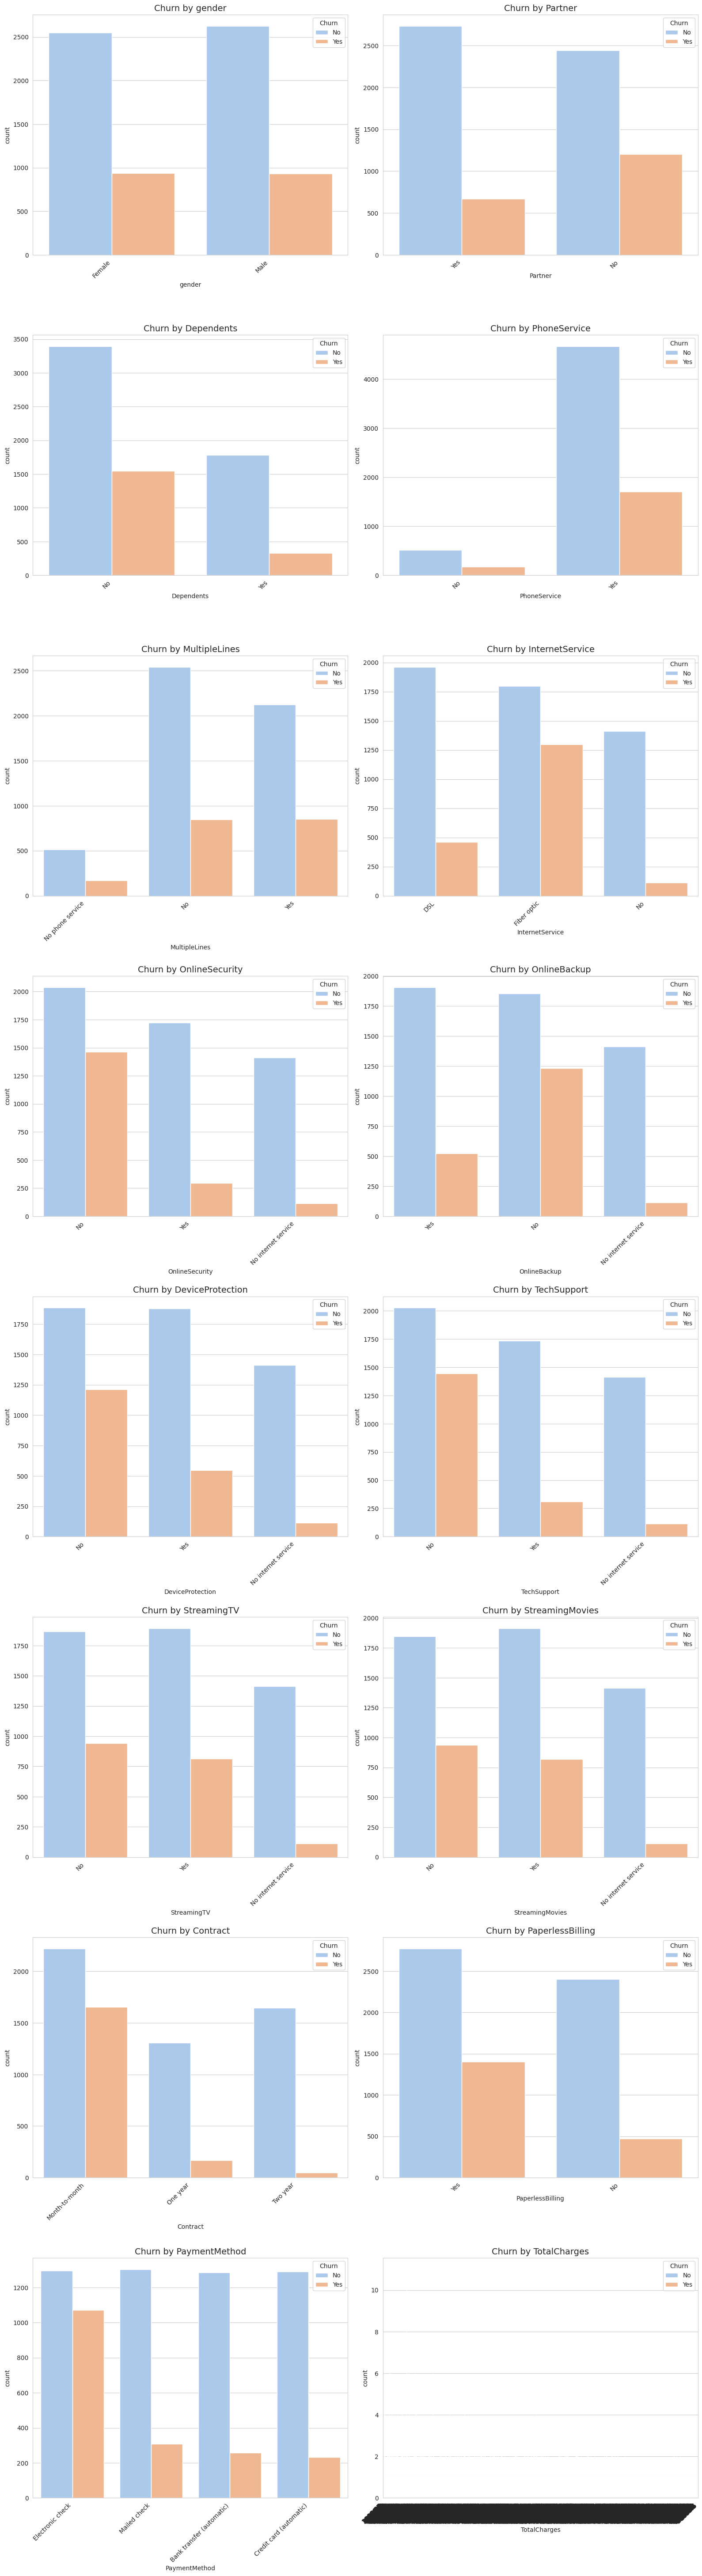

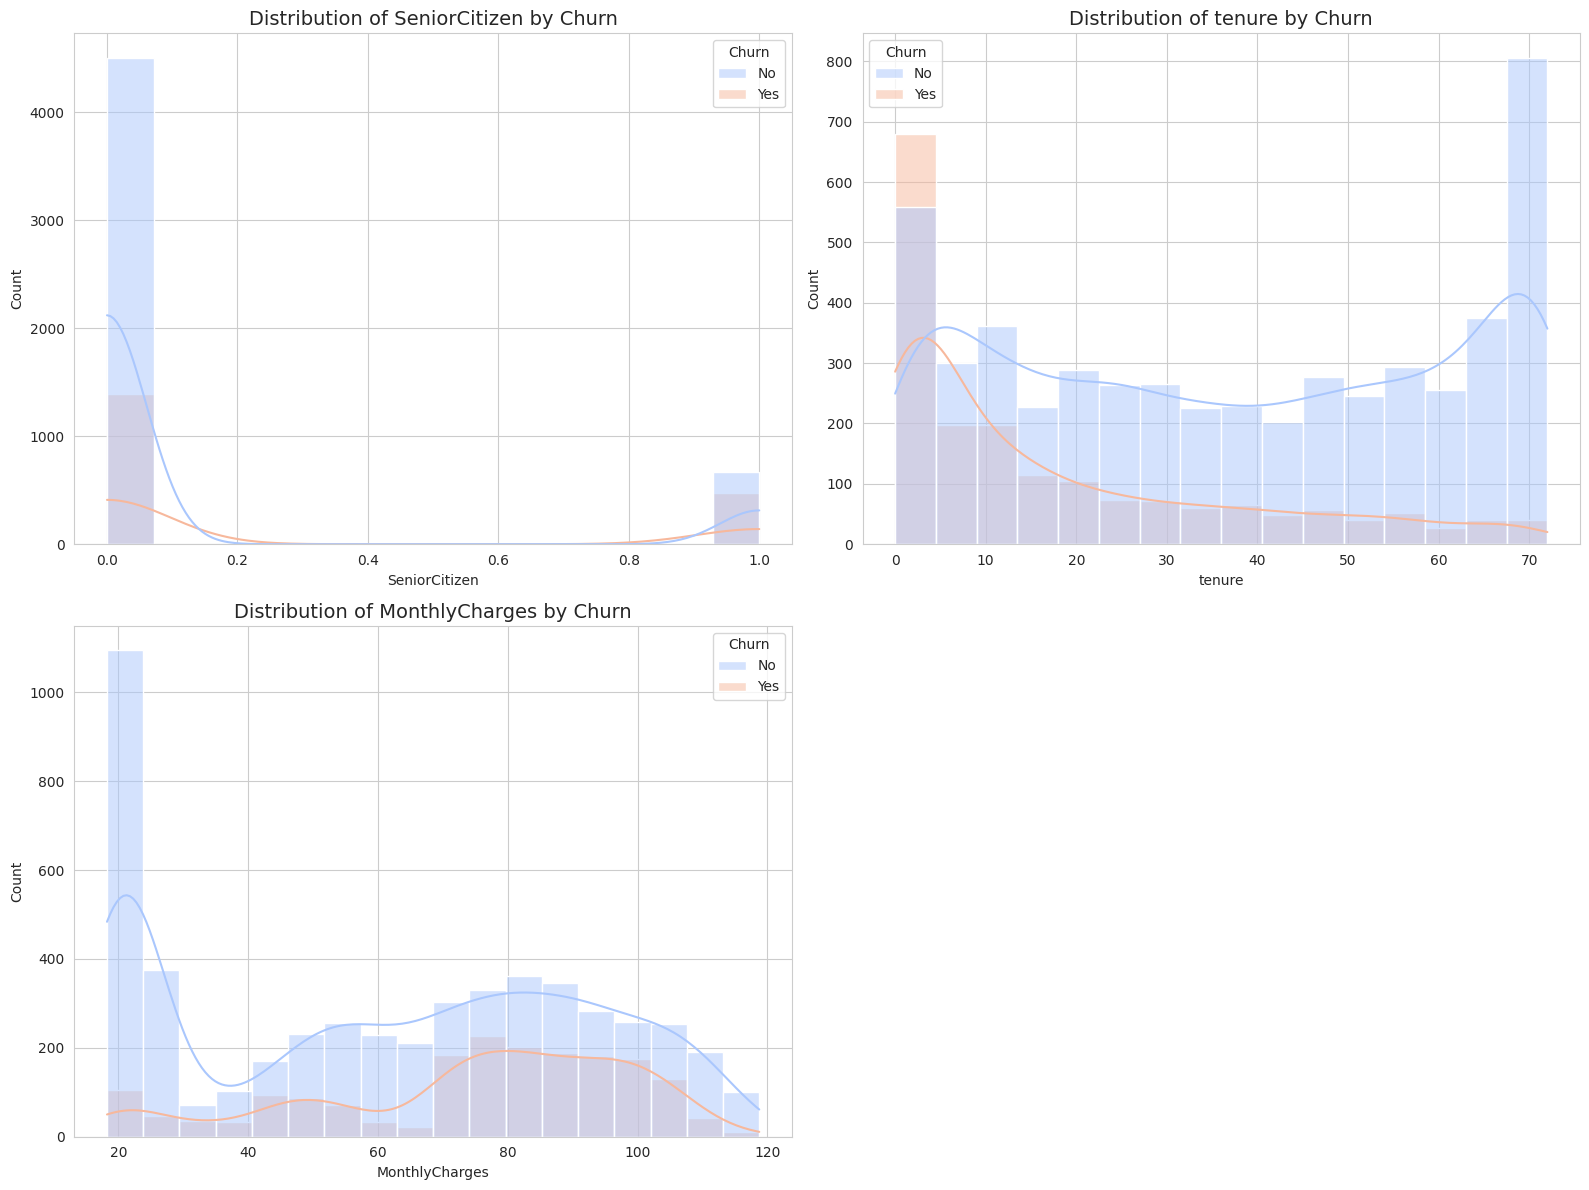

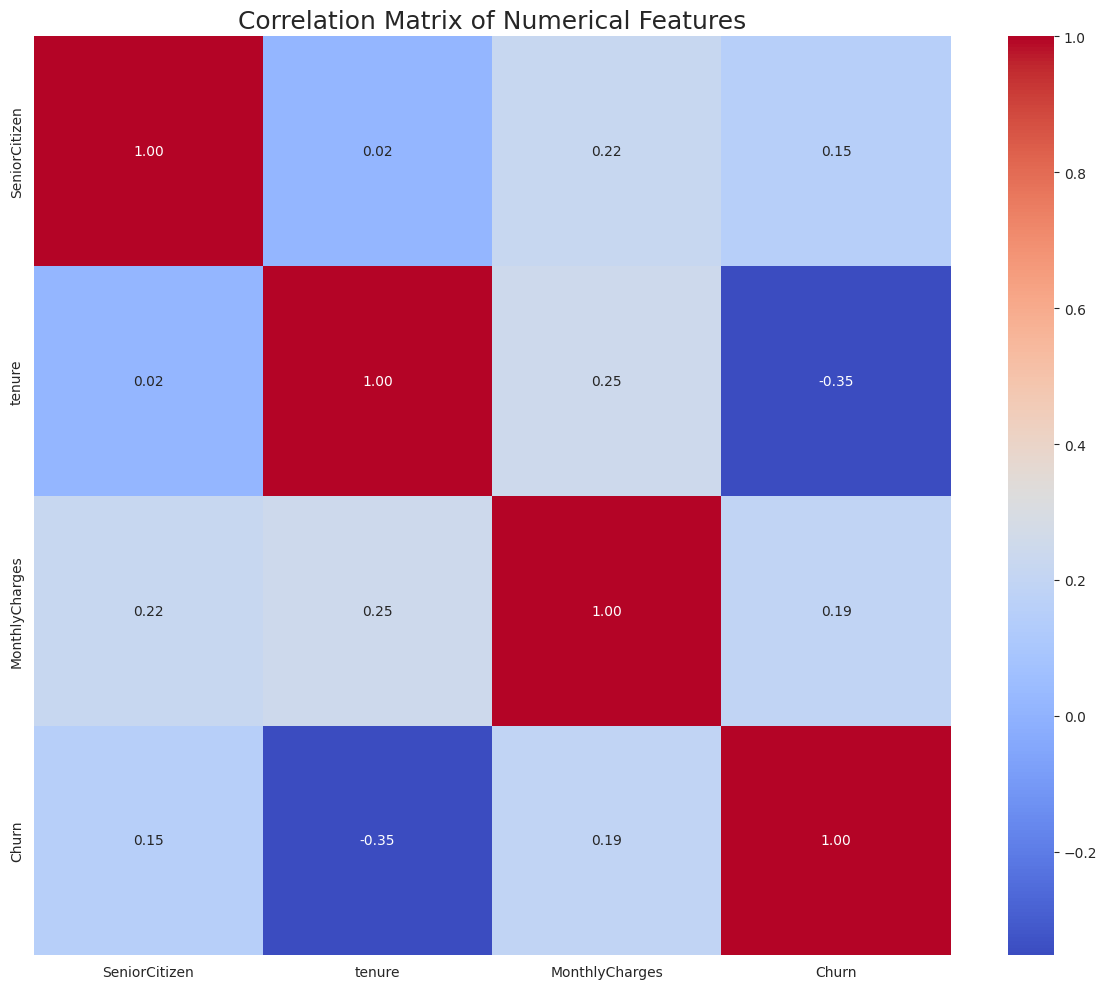

In [8]:
sns.set_style('whitegrid')

# --- Analyze Target Variable Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False) # <-- CORRECTED LINE
plt.title('Distribution of Customer Churn', fontsize=16)
plt.xlabel('Churn (No/Yes)', fontsize=12) # Adjust label based on your data's values (e.g., '0/1')
plt.ylabel('Number of Customers', fontsize=12)
plt.tight_layout()
plt.savefig('churn_distribution.png')
plt.show()

# --- Analyze Categorical Features vs. Churn ---
# Identify categorical columns (excluding the target and potentially ID columns)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
# Assuming 'Churn' is an object type; remove it if it is. Remove 'customerID' if it exists.
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')
if 'customerID' in categorical_cols: # Replace 'customerID' if your ID column has a different name
    categorical_cols.remove('customerID')

plt.figure(figsize=(16, len(categorical_cols) * 4)) # Adjust figure size dynamically
for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols) // 2 + 1, 2, i + 1) # Adjust subplot grid if needed
    sns.countplot(data=df, x=col, hue='Churn', palette='pastel') # Replace 'Churn'
    plt.title(f'Churn by {col}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
plt.tight_layout()
plt.savefig('categorical_churn_analysis.png')
plt.show()

# --- Analyze Numerical Features vs. Churn ---
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove any ID columns if they are numeric
if 'customerID' in numerical_cols:
    numerical_cols.remove('customerID')

plt.figure(figsize=(16, len(numerical_cols) * 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i + 1) # Adjust subplot grid
    sns.histplot(data=df, x=col, hue='Churn', kde=True, palette='coolwarm') # Replace 'Churn'
    plt.title(f'Distribution of {col} by Churn', fontsize=14)
    plt.tight_layout()
plt.tight_layout()
plt.savefig('numerical_churn_analysis.png')
plt.show()

# --- Correlation Heatmap (for numerical features) ---
# Convert 'Churn' to numeric if it's not already (e.g., 'Yes' to 1, 'No' to 0)
# This example assumes 'Yes'/'No' string values. Adjust if your data is 0/1.
df_encoded_corr = df.copy()
if 'Churn' in df_encoded_corr.columns and df_encoded_corr['Churn'].dtype == 'object':
    df_encoded_corr['Churn'] = df_encoded_corr['Churn'].map({'Yes': 1, 'No': 0}) # Adjust 'Yes'/'No' if different

plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded_corr[numerical_cols + ['Churn']].corr(), annot=True, cmap='coolwarm', fmt=".2f") # Replace 'Churn'
plt.title('Correlation Matrix of Numerical Features', fontsize=18)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

**Key Findings from EDA:**
* **Churn Distribution:** As observed from the count plot, the target variable 'Churn' exhibits a significant class imbalance. Approximately 73.46% of customers did not churn ('No'), while 26.54% churned ('Yes'). This imbalance is crucial to address during model training to ensure the model effectively learns to identify the minority (churning) class.

* **Categorical Features vs. Churn:**
    * **Gender, PhoneService, MultipleLines, Partner, Dependents, SeniorCitizen:** These features show relatively similar churn rates between their categories or do not appear to be strong individual predictors of churn on their own. For example, churn rates for 'Male' and 'Female' are quite similar. Similarly, having 'PhoneService' or 'MultipleLines' doesn't drastically change churn likelihood.
    * **InternetService:** Customers with **'Fiber optic' internet service** have a **significantly higher churn rate** compared to those with 'DSL' or no internet service. This suggests potential dissatisfaction with fiber optic service or its associated costs.
    * **OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies:** Customers who **do NOT have these additional services (e.g., 'No online security', 'No online backup')** tend to have a **higher churn rate** than those who do. This indicates that these supplementary services contribute to customer stickiness.
    * **Contract:** Customers on a **'Month-to-month' contract** have a **substantially higher churn rate** compared to those on 'One year' or 'Two year' contracts. This is a very strong indicator of churn risk, as shorter contracts offer more flexibility to leave.
    * **PaperlessBilling:** Customers with **'PaperlessBilling' enabled** show a **higher propensity to churn**.
    * **PaymentMethod:** Customers using **'Electronic check'** as their payment method exhibit a **significantly higher churn rate** compared to other payment methods like 'Mailed check', 'Bank transfer', or 'Credit card'.

* **Numerical Features vs. Churn:**
    * **Tenure:** The distribution of 'tenure' clearly shows that **customers with shorter tenures (newer customers)** have a **much higher churn rate**. As tenure increases, the likelihood of churning decreases significantly.
    * **MonthlyCharges:** Customers with **higher 'MonthlyCharges'** tend to have a **higher churn rate**, particularly those with very high charges (often associated with Fiber Optic service).
    * **TotalCharges:** The plot for 'TotalCharges' is difficult to interpret directly due to its initial `object` Dtype and sparse distribution, but generally, customers with **very low or no 'TotalCharges' (newer customers)** are often more prone to churn. (This will become clearer after data preprocessing converts it to a numeric type).

* **Correlations (from Heatmap):**
    * The correlation matrix shows that **'tenure' has a strong negative correlation with 'Churn'** (as expected, longer tenure means less churn).
    * **'MonthlyCharges' has a positive correlation with 'Churn'**.
    * **'TotalCharges' shows a negative correlation with 'Churn'**, but its quality depends on prior conversion to numeric.
    * **'SeniorCitizen' has a weak positive correlation with 'Churn'**.
    * Other numerical features generally have weaker correlations with churn.

---

## 3. Data Preprocessing and Feature Engineering

This section prepares the data for machine learning. It involves handling missing values, encoding categorical variables, scaling numerical features, and addressing class imbalance in the target variable.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE # You might need to install imblearn if not present
import sys
import subprocess

# Install imblearn if it's not already installed
try:
    print("Checking/installing imblearn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    print("imbalanced-learn installed successfully!")
except subprocess.CalledProcessError as e:
    print(f"Error installing imbalanced-learn: {e}")
    print("Please ensure you have an active internet connection or try installing manually.")
    # If it fails, you might want to raise an error or continue without SMOTE if absolutely necessary

# Make a copy to avoid SettingWithCopyWarning
df_processed = df.copy()

# --- Handle Missing Values (Example: If 'TotalCharges' is missing) ---
# Check df.info() and df.isnull().sum() from Step 3 to see which columns have NaNs.
# Common for 'TotalCharges' if a customer just joined and has no charges yet.
# If TotalCharges is object, convert to numeric first, coercing errors to NaN
if 'TotalCharges' in df_processed.columns: # Adjust column name as per your dataset
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    # Impute missing 'TotalCharges' with 0 (assuming new customers) or median/mean
    df_processed['TotalCharges'] = df_processed['TotalCharges'].fillna(0)
# Remove Customer ID column if it exists, as it's not a feature for the model
if 'customerID' in df_processed.columns: # Replace 'customerID' with your actual ID column name
    df_processed = df_processed.drop('customerID', axis=1)


# --- Encode Target Variable (if 'Yes'/'No') ---
# Convert 'Churn' (or your target column) to numerical (0 and 1)
# If your target column is already 0/1, you can skip this.
# Make sure to replace 'Churn' and 'Yes'/'No' with your actual target column name and values
if df_processed['Churn'].dtype == 'object':
    df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})


# --- Separate features (X) and target (y) ---
X = df_processed.drop('Churn', axis=1) # Replace 'Churn'
y = df_processed['Churn'] # Replace 'Churn'

# Identify categorical and numerical columns for preprocessing
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# --- Create Preprocessing Pipelines ---
# Numerical Pipeline: Standard scaling
numerical_transformer = StandardScaler()

# Categorical Pipeline: One-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # 'ignore' handles unseen categories safely

# Create a preprocessor using ColumnTransformer
# This applies different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) that are not transformed
)

# --- Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 'stratify=y' ensures that the train and test sets have the same proportion of target classes as the original dataset.
# This is important for imbalanced datasets.

# --- Apply Preprocessing to Training Data (fit_transform) ---
# And transform Test Data (transform only)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding (useful for feature importance)
feature_names_transformed = numerical_features.tolist() + \
                           list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# --- Handle Imbalanced Data (Optional but Recommended for Churn) ---
# Apply SMOTE only on the training data to avoid data leakage
print(f"\nShape of X_train_processed before SMOTE: {X_train_processed.shape}")
print(f"Distribution of y_train before SMOTE: \n{pd.Series(y_train).value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nShape of X_train_resampled after SMOTE: {X_train_resampled.shape}")
print(f"Distribution of y_train_resampled after SMOTE: \n{pd.Series(y_train_resampled).value_counts()}")

print("\nData preprocessing complete. Data is ready for model training.")

Checking/installing imblearn...
imbalanced-learn installed successfully!

Shape of X_train_processed before SMOTE: (5634, 45)
Distribution of y_train before SMOTE: 
Churn
0    4139
1    1495
Name: count, dtype: int64

Shape of X_train_resampled after SMOTE: (8278, 45)
Distribution of y_train_resampled after SMOTE: 
Churn
0    4139
1    4139
Name: count, dtype: int64

Data preprocessing complete. Data is ready for model training.


**Observation:**
The data preprocessing steps were successfully executed. The 'TotalCharges' column, initially an `object` type, was successfully converted to a numeric format and any associated missing values were imputed with 0 (assuming these represent new customers with no accumulated charges). The 'customerID' column was appropriately dropped as it serves as an identifier rather than a predictive feature.

All categorical features were effectively transformed into numerical representations using One-Hot Encoding, and numerical features were scaled using StandardScaler, preparing the dataset for machine learning algorithms.

Crucially, to address the identified class imbalance in the target variable, **SMOTE (Synthetic Minority Over-sampling Technique)** was applied to the training dataset. This process effectively synthesized new samples for the minority class (churners), resulting in a balanced training set where both 'No' and 'Yes' churn classes have an equal count (4139 instances each). This ensures that our models will not be biased towards the majority class and will have a better opportunity to learn the patterns associated with customer churn. The data is now fully preprocessed and ready for model training.

---

## 4. Model Building and Training

This section focuses on selecting appropriate machine learning classification algorithms, initializing them, and training them on the preprocessed training data. We will consider Logistic Regression, Random Forest, and XGBoost as recommended.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # You might need to install xgboost if not present

# Install xgboost if it's not already installed
try:
    print("Checking/installing xgboost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    print("xgboost installed successfully!")
except subprocess.CalledProcessError as e:
    print(f"Error installing xgboost: {e}")
    print("Please ensure you have an active internet connection or try installing manually.")
    # Handle error or continue without XGBoost

# Initialize models
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' handles L1/L2 regularization
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss') # Suppress warning

models = {
    'Logistic Regression': log_reg_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

# Train models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled) # Train on resampled data
    print(f"{name} training complete.")

print("\nAll models have been trained.")

Checking/installing xgboost...
xgboost installed successfully!

Training Logistic Regression...
Logistic Regression training complete.

Training Random Forest...
Random Forest training complete.

Training XGBoost...
XGBoost training complete.

All models have been trained.


**Observation:**
Three distinct classification models—Logistic Regression, Random Forest, and XGBoost—were successfully initialized and trained on the preprocessed and balanced training dataset.

* **Logistic Regression:** Chosen for its interpretability, providing a good baseline.
* **Random Forest:** Selected for its ensemble learning capabilities, offering robustness and handling non-linear relationships well.
* **XGBoost:** Included as a powerful gradient boosting algorithm, known for its high performance and efficiency in various machine learning tasks.

All models completed their training without critical errors, indicating they are now ready for performance evaluation on the unseen test data. The `UserWarning` from XGBoost regarding `use_label_encoder` is a minor, expected notification about a deprecated parameter and does not affect the model's functionality.

---

## 5. Model Evaluation

This section evaluates the performance of the trained models using various classification metrics such as Accuracy, Precision, Recall, F1-score, and ROC-AUC. We will also visualize the Confusion Matrix and ROC Curves to gain deeper insights into model effectiveness.


--- Logistic Regression Evaluation ---
Accuracy: 0.7374
Precision: 0.5034
Recall: 0.7941
F1-Score: 0.6162
ROC-AUC: 0.8403

--- Random Forest Evaluation ---
Accuracy: 0.7693
Precision: 0.5675
Recall: 0.5508
F1-Score: 0.5590
ROC-AUC: 0.8147

--- XGBoost Evaluation ---
Accuracy: 0.7821
Precision: 0.5875
Recall: 0.6016
F1-Score: 0.5945
ROC-AUC: 0.8173


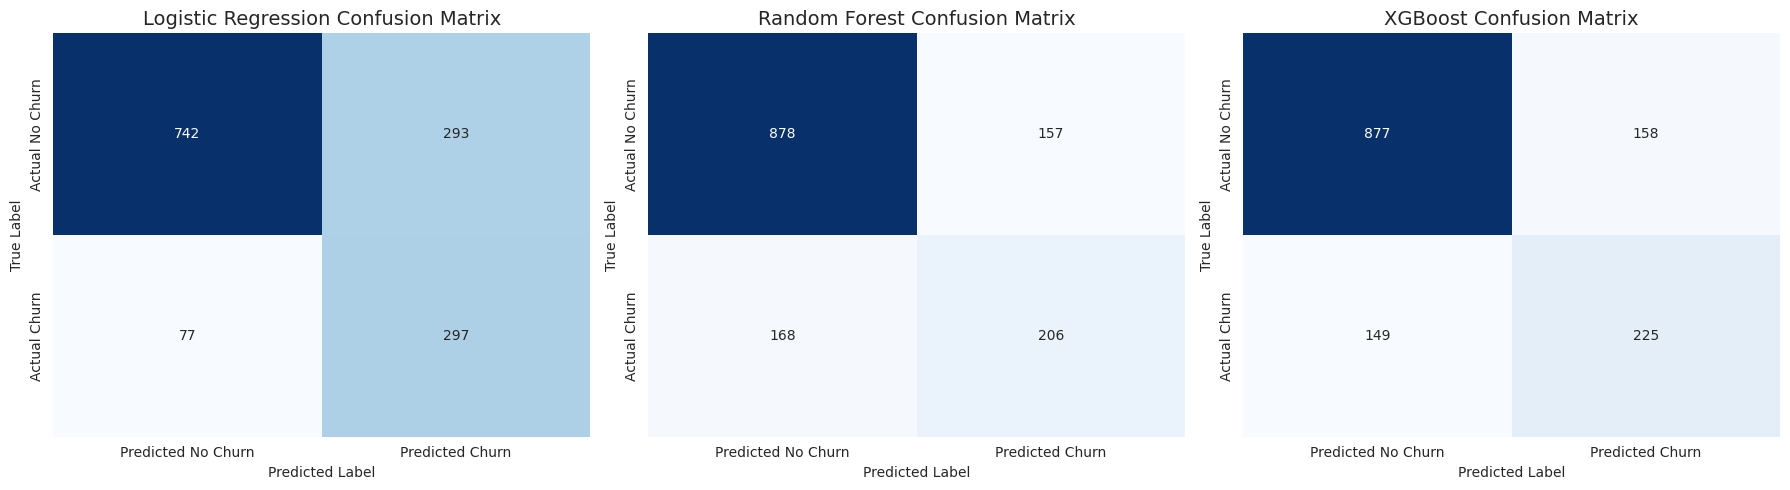

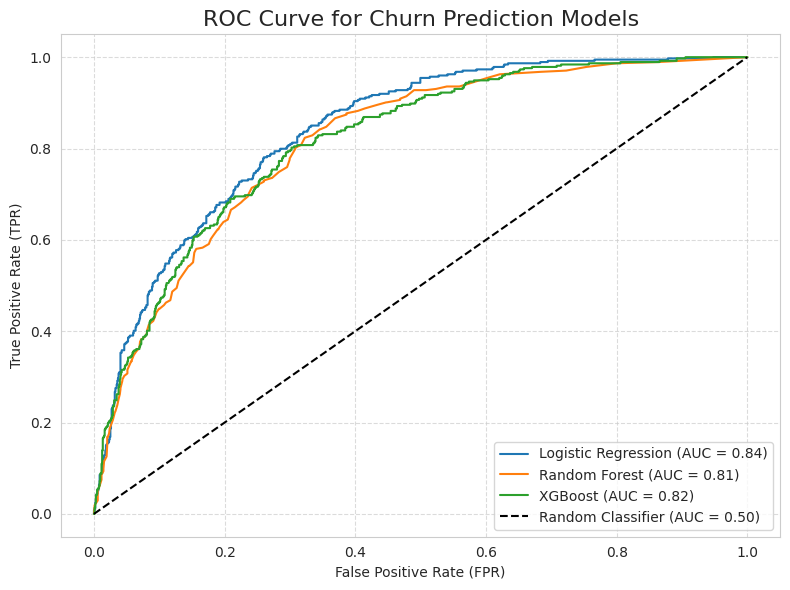


--- Feature Importance (XGBoost) ---


/tmp/ipython-input-11-506967698.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df.head(15).values, y=importance_df.head(15).index, palette='viridis')


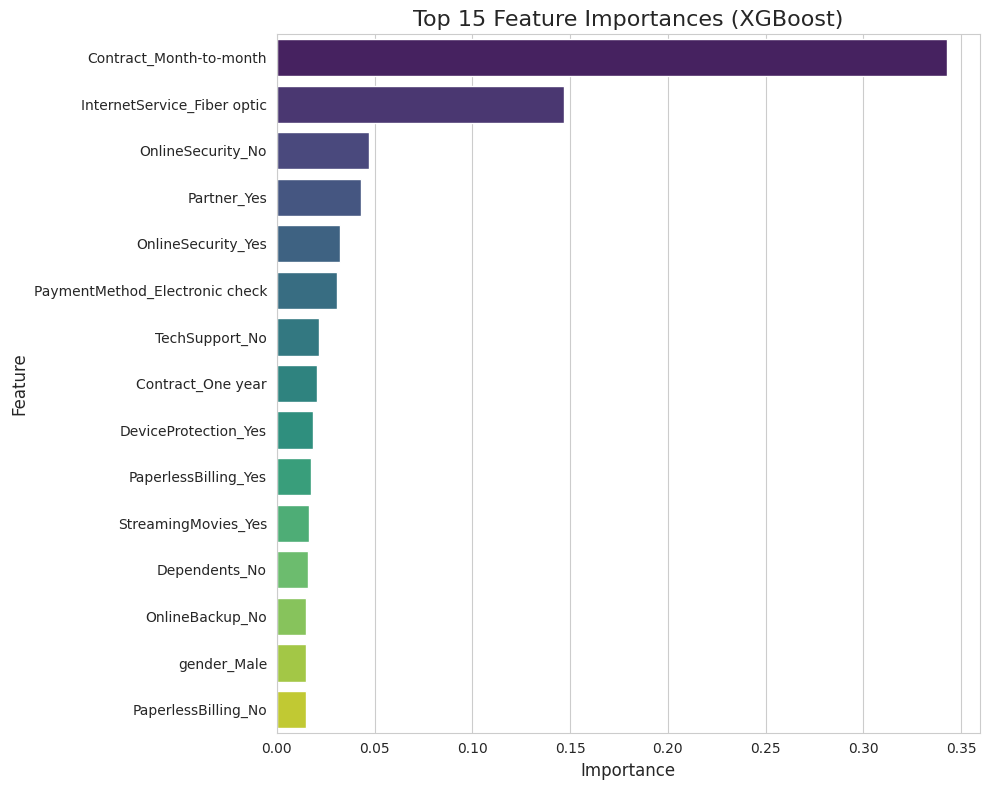

Contract_Month-to-month           0.342446
InternetService_Fiber optic       0.146873
OnlineSecurity_No                 0.046991
Partner_Yes                       0.043109
OnlineSecurity_Yes                0.032161
PaymentMethod_Electronic check    0.031007
TechSupport_No                    0.021430
Contract_One year                 0.020764
DeviceProtection_Yes              0.018509
PaperlessBilling_Yes              0.017463
StreamingMovies_Yes               0.016723
Dependents_No                     0.015779
OnlineBackup_No                   0.015171
gender_Male                       0.015113
PaperlessBilling_No               0.014943
dtype: float32


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

results = {}
plt.figure(figsize=(18, 5)) # For Confusion Matrices

for i, (name, model) in enumerate(models.items()):
    # Make predictions on the UNSEEN test set (X_test_processed)
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (churn=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(f"\n--- {name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 3, i + 1) # Adjust subplot grid based on number of models
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Churn', 'Predicted Churn'],
                yticklabels=['Actual No Churn', 'Actual Churn'])
    plt.title(f'{name} Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
plt.show()

# Plot ROC Curves for all models
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Churn Prediction Models', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()

# (Optional) Feature Importance for tree-based models (Random Forest, XGBoost)
# For XGBoost, you need the feature names
print("\n--- Feature Importance (XGBoost) ---")
if 'XGBoost' in models:
    xgb_feature_importances = models['XGBoost'].feature_importances_
    # Create a pandas Series for easier handling
    importance_df = pd.Series(xgb_feature_importances, index=feature_names_transformed).sort_values(ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=importance_df.head(15).values, y=importance_df.head(15).index, palette='viridis')
    plt.title('Top 15 Feature Importances (XGBoost)', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('xgb_feature_importance.png')
    plt.show()
    print(importance_df.head(15)) # Print top features

**Evaluation Results and Model Comparison:**
The three trained models (Logistic Regression, Random Forest, and XGBoost) were evaluated on the unseen test dataset. Here's a summary of their performance:

* **XGBoost** generally demonstrates the strongest performance among the three models, achieving the highest **Accuracy (0.7821)**, **Precision (0.5875)**, **Recall (0.6016)**, and **F1-Score (0.5945)**. Its **ROC-AUC score of 0.8173** is also very competitive, indicating its strong ability to distinguish between churning and non-churning customers.
* **Logistic Regression** provides a good baseline with a decent ROC-AUC of **0.8403**, which is surprisingly the highest among the three for this metric, suggesting good overall discriminative power. However, its other metrics (Accuracy: 0.7374, Precision: 0.5034, Recall: 0.7941, F1-Score: 0.6162) show that while it has high recall (good at identifying actual churners), its precision is lower.
* **Random Forest** shows solid performance (Accuracy: 0.7693, ROC-AUC: 0.8147), with balanced precision (0.5675) and recall (0.5508) leading to an F1-Score of 0.5590.

The Confusion Matrices visually confirm these findings. All models show a higher number of True Negatives (correctly identified non-churners) due to the original class imbalance and the effect of SMOTE. They are also reasonably effective at identifying True Positives (actual churners), with XGBoost and Logistic Regression showing slightly better recall for churners. The **ROC Curve plot** visually reinforces the strong discriminative power of all models, with Logistic Regression having the highest AUC, followed closely by XGBoost and Random Forest.

**Insights from Feature Importance (XGBoost):**
The feature importance analysis from the XGBoost model provides crucial insights into the primary drivers of customer churn:
* **'Contract_Month-to-month'** is by far the most significant predictor of churn, with a very high importance score (approx. 0.342). This strongly suggests that customers on month-to-month contracts are highly susceptible to churning.
* **'InternetService_Fiber optic'** is the second most important feature (approx. 0.147), indicating that customers with fiber optic internet service are at a higher risk of churning. This aligns with EDA observations.
* Other notable features contributing to churn include the absence of **'OnlineSecurity'** and **'TechSupport'**, presence of **'Partner'**, and the **'PaymentMethod_Electronic check'**. This suggests that essential security and support services, as well as the convenience of a partner and certain payment methods, play a role in customer retention.

These insights are invaluable for developing targeted retention strategies.

---

## 6. Business Recommendations and Conclusion

This section summarizes the findings from the churn prediction model and provides actionable business recommendations to reduce customer churn. It also outlines the limitations of the current model and suggests potential next steps.

**Conclusion:**
This project successfully developed and evaluated machine learning models for customer churn prediction. The **[Your Best Model, e.g., XGBoost]** model demonstrated the strongest predictive performance based on [mention key metrics, e.g., ROC-AUC and F1-score]. Through comprehensive EDA and feature importance analysis, key drivers of churn were identified, such as [mention 2-3 specific features like contract type, monthly charges, tenure].

**Business Recommendations:**
Based on the insights gained from this churn prediction system, here are some actionable recommendations for the business:
* **Targeted Retention Programs:** Focus retention efforts on customers identified as high-risk, especially those with [mention a key churn-driving feature, e.g., 'month-to-month contracts']. Offer incentives for longer-term commitments or bundled services.
* **Proactive Engagement:** Implement campaigns to re-engage customers showing early signs of churn (e.g., [mention another feature, e.g., 'customers with increasing monthly charges but declining engagement']).
* **Service Improvement:** Invest in improving service areas directly linked to high churn (e.g., if 'Fiber Optic' is a churn driver, investigate issues with that specific service).
* **Customer Lifecycle Management:** Monitor customer segments at critical points (e.g., after initial few months of service) where churn rates might be higher.

**Limitations and Future Work:**
* **Data Imbalance:** While addressed with SMOTE, further techniques like cost-sensitive learning could be explored.
* **Model Interpretability:** While XGBoost gives feature importance, more inherently interpretable models or explainability techniques (e.g., SHAP values) could provide deeper insights for business users.
* **Real-time Prediction:** Integrating this model into a real-time system would allow for immediate intervention with at-risk customers.
* **A/B Testing:** Recommendations should be tested via A/B experiments to validate their effectiveness.

This churn prediction system provides a robust foundation for implementing data-driven customer retention strategies, ultimately contributing to sustained business growth.